## Installation instructions

```bash
pip install music21
pip install geopy
pip install folium
pip install pandas
```

After installing music21, run the following

```python
import music21
music21.configure.run()
```

Follow the steps to configure music21

# Milestone 2
## 1. Gathering the data

**Remove for submission**

Here you can show that you understand your data and know how to use it. You can be brief in your answers. Section 1 may be supported with informative plots.
- [ ] Describe the dataset you selected and the information represented in it.
- [x] Based on your research question(s), why did you select this dataset?
- [ ] What aspects of the researched phenomena does the data (not) represent?
- [x] Where did you get your data from?
- [x] How did you get it?
- [x] What is the maximum available amount in theory (in the case of incomplete data acquisition)?
- [ ] If working on partial data, how representative is your sample for the full dataset?


As mentioned in the previous Milestone, answering our research questions related to the modal organization of Chinese Folk Songs (hereafter CFS) across China requires a dataset with the following properties:
1. The CFS must come from diverse regions of China
2. The origin of each song must be annotated
3. If possible, the tonic of each song should be annotated

By simply querying these requests on a search engine, we found the [Essen Folksong Database](http://www.esac-data.org/). This database contains more than 20'000 scores of folksongs, of which approximately 2250 come from China. This dataset is particularly interesting as it contains the regional information required to answer our research questions. Indeed, not only are the Chinese scores classified into 4 distinct geographical regions (Han, Natmin, Shanxi, Xinhua), which shows diversity in their origins, but each piece also contains a more precise provenance (the province or city). Moreover, each song is annotated with its tonic, though it is unclear whether the annotation is manual or if it has been inferred by a software. Therefore, as this dataset fulfills the three criteria above, it is well suited for our project and it will allow us to analyse all of our researched phenomena. We can easily download all the relevant data of the Essen Collection from the [KernScore database](https://kern.humdrum.org/cgi-bin/browse?l=essen/asia/china) as a ZIP file containing all songs in *\*\*kern* format.

It is crucial to note that our dataset can never be complete. Indeed, as we also explained in M1, CFS were an oral tradition and most of the transcriptions were made after the founding of New China in 1949. It is therefore very likely that many songs were forgotten throughout history. However, with almost 2250 CFS, we are confident that grouping them by region will allow us to get a representative sample of the folk songs in each area.

Lastly, as the folk music of China is known to mainly use the pentatonic scales[<sup>1</sup>](https://digitalcommons.lsu.edu/cgi/viewcontent.cgi?article=2761&context=gradschool_dissertations)
, and as we confirmed this claim by manually inspecting several Chinese songs of the Essen Database, where we observed that each of them mainly used 5 pitches, we will assume for the rest of this project that all the CFS from our dataset are in pentatonic scale.

## 2. Data format

### 2.1 Kern Format
Originally, the Essen Folksong Database is in a particular format that is inspired by the *Jianpu* notation. While it may have been interesting to work with this format to analyze CFS, for simplicity reasons, we will use a translation of this database in *\*\*kern* format. As a summary, the information in *\*\*kern* files is represented as follows:
pitches are represented by letters and durations by numbers.

* Pitch
  * a-g are the absolute pitches above middle C
  * A-G are the absolute pitches below middle C
  * You can double any letter to represent higher or lower pitches
* Duration
  * 1 represents a whole note
  * 2 represents a half note
  * 4 represents a quarter note
  * etc...
* Accidentals
  * \# represents the sharp
  * \- represents the flat

On top of musical data, the *\*\*kern* files can also contain metadata in the format of comments or references. These are followed by a code that denotes what it is about. For instance, the title of the piece is typically indicated in a comment with the code `OTL`.


As a concrete example, here is the *\*\*kern* representation of the following score titled *My Kern Example*:

![score](img/example_score.png)
```
!!!OTL: My Kern Example
**kern
{
1B
4g-
8ff
}
```

*\*\*kern* files also allow more complex music representation (e.g. glissando), which we will however mostly not need in this project. [The Humdrum website](https://www.humdrum.org/rep/kern/) provides a complete reference of the music notation in this format.


### 2.2 Examples on a single score
Luckily, we do not need to write a parser to work with \*\*kern files, as this can be done using the *music21* module, which can be easily installed via *pip*.

In [2]:
# Imports 

from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from geopy.geocoders import Nominatim
import re
import folium
import networkx as nx
plt.rcParams["figure.figsize"] = (20,5)


#NOTE TO RAVI AND ZIJUN : This is the MuseCore path on my Computer, you will need to download MuseScore and to specify the path yourself
#Maybe for the final report we indeed only let the .configure thing (although it did not work on my computer)
environment.set('musescoreDirectPNGPath', 'C:\Program Files\MuseScore3\\bin\\MuseScore3.exe')

As an example, let's load one song from the regional category *Han* and display it.

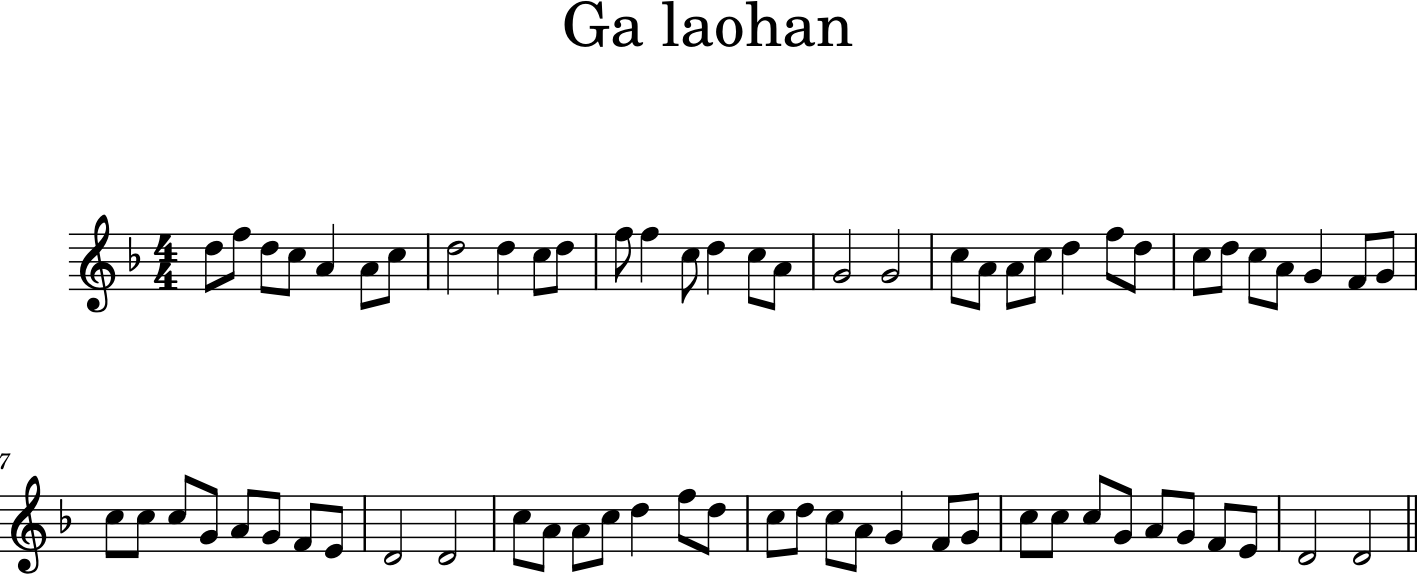

In [4]:
score = converter.parse("./data/han/han0111.krn")
score.show()

First, we are interested in the origin of the song. Apart from the regional category (*Han*), the more precise origin of the song is contained in a `GlobalReference` with the code `ARE`. One way to access it is to iterate over all the elements and only print it if it is an element of that type with the correct code.

In [5]:
for element in score:
    if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
        print(element.value)

Asia, China,ÿQinghai, Osten


Second, as our analysis will rely on scale degrees, we will need to access the pitches and their durations as well as the tonic. The following snippet allows us to access all the notes of the first measure and the tonic of the piece.

In [6]:
for part in score.parts:
    for element in part.measure(0):
        if type(element) is key.Key:
            print(f"The tonic is : {element.tonic}")
        if type(element) is note.Note:
            print(element.pitch, element.duration.quarterLength)

The tonic is : F
D5 0.5
F5 0.5
D5 0.5
C5 0.5
A4 1.0
A4 0.5
C5 0.5


The code snippet above shows that the tonic of this piece is F. However, after a short analysis, we concluded that it was unlikely that F was indeed its tonic. Indeed, for the scope of this project, we simply define the tonic as a central pitch, i.e. the most recurring pitch that falls on high tonal hierarchy. Since there are only two short F in this song, it doesn't correspond to our definition. However, we notice that the D is often used on high tonal hierachy (i.e. it is the first note of the score and often comes as the first note of the measure)

Therefore we developped the following algorithm that returns the tonic following our own definition. It computes a score for each pitch based on the pitch duration and the tonal hierarchy. The note with the highest score is then understood as the tonic. As the for-loop that is used is time costly, we decided to also use it to return the pitch classes as well as the 5 most central pitches, using our own definition of centrality.


In [10]:
def get_tonic_and_pitch_classes(score):
    """
    This function accepts a score and returns its tonic, pitch classes, and 5 most central pitches,
    using the method described above.
    """
    try:
        note_scores = dict()
        for part in score.parts:
            for measure in part:
                if type(measure) is not stream.Measure:
                    continue
                for note_ in measure:
                    if type(note_) is not note.Note:
                        continue
                    if note_.name in note_scores.keys():
                        note_scores[note_.name] += note_.duration.quarterLength * note_.beatStrength
                    else:
                        note_scores[note_.name] = note_.duration.quarterLength * note_.beatStrength
        tonic = max(note_scores, key=note_scores.get)
    except:
        tonic = None
    
    pitchclasses = list(note_scores.keys())
    top5 = sorted(note_scores, key=note_scores.get, reverse=True)[:5]
    return tonic, pitchclasses, top5

We can now infer the tonic of using this function

In [14]:
tonic, _, _ = get_tonic(score)
print(f"The tonic is : {tonic}")

The tonic is : D


Our custom algorithm thus infers D as being the tonic, which corresponds to our manual analysis of this piece.

With this information, we can now infer what pentatonic scale is used in this piece. For this purpose, we first need to transpose the piece to C relatively to its tonic (in this case a transposition of -2 since there are 2 semitones between C and D). We can easily use *music21*'s `transpose` method to do it

In [5]:
transposed_score = score.transpose(-2)

We can now use *music21*'s `plot` method to get a general plot of the pitch classes used in this transposed piece.

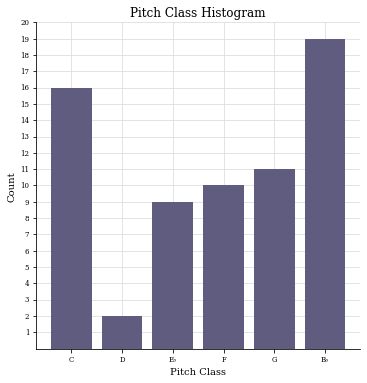

In [6]:
transposed_score.plot('histogram', 'pitchclass')

A visual inspection of this plot shows us that the most used pitches after transposing are C E<sub>b</sub> F G B<sub>b</sub> which corresponds to the *minor* pentatonic scale.

### 2.3 Statistics on the whole dataset

#### Creation of dataframe

In order to get an overview of the whole dataset, we will need to load it completely. As the files are divided into four different folders corresponding to the four regional categories, we first need to define the names of each of them.

In [15]:
regions = ["han", "natmin", "shanxi", "xinhua"]

We then define the function below that returns all *\*\*kern* scores in the given `path`, parsed with `music21`'s function.

In [16]:
def load_scores(path):
    """
    The function accepts a path and loads the .krn files in the path into a list.
    The pieces that are successfully parsed by the music21 parsers are stored in the scores list.
    In case the parser fails to load any file, they are stored in failed_scores.
    The count of total scores and failed scores are stores in total and failed counters.
    """
    
    pieces = {"scores": [], "failed_scores": [], "total": 0, "failed": 0}
    for file in tqdm(glob.glob(path+"/*.krn")):
        pieces["total"] += 1
        try:
            pieces["scores"].append(converter.parse(file))
        except:
            pieces["failed"] += 1 
            pieces["failed_scores"].append(converter.parse(file))
            
    return pieces

We can now iterate over the four regions, also corresponding to the four files, to create the paths in order to retrieve all scores of our dataset.

In [18]:
music_data = {}

for region in regions:
    music_data[region] = load_scores("./data/" + region)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 77.39it/s]


##### Logic for the creation of one row in the data frame.

Currently, the music scores are store in a dictionary `music_data` with a key as the geographical region. For practical reasons, we will convert it into a `panda`'s `DataFrame`. The conversion will use the following logic:

- Create an empty list
- For each geographic region
    - Get the music pieces of the region.
    - For each piece
        1. we get the title of the piece
        2. we get the number notes in the piece
        3. we get the location to which the piece belongs (finer than region).
        4. we use the `get_tonic` function to obtain the tonic, pitch classes, and the 5 most central pitch classes present in the piece.
        5. We transpose the piece to C and obtain the new pitch classes using the `get_tonic` function.
            - We calculate the number of semitones between the tonic of the piece and 'C' and transpose the piece by that value
        6. We then get the pitches present in the transposed piece
        7. All this information is appended to the list
- Create a DataFrame by given appropriate titles to the list
        
The implementation of this algorithm is given below.

In [23]:
# create a empty list to store information about each piece.
CFS_list = []

for region in tqdm(music_data):
    for score in music_data[region]["scores"]:
        
        title = score.metadata.title
        
        for element in score:
            if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
                location = element.value
                
        tonic, pitchclasses, _ = get_tonic(score)
        num_pitchclass = len(pitchclasses)
        pitches = [str(pitch) for pitch in score.pitches]
        num_notes = len(pitches)
        
        # transposing
        i = interval.Interval(pitch.Pitch(tonic), pitch.Pitch("C")).semitones
        scoreNew = score.transpose(i)
        
        tonic_transposed, pitchclasses_transposed, top5 = get_tonic(scoreNew)
        pitches_transposed = [str(pitch) for pitch in scoreNew.pitches]
        
        CFS_list.append([region, title, location, tonic, pitches, num_notes, pitchclasses, num_pitchclass, tonic_transposed, pitches_transposed, pitchclasses_transposed, top5])
CFS_full = pd.DataFrame(CFS_list, columns=["region", "title", "location", "tonic", "pitches", "num_notes", "pitchclasses", "num_pitchclasses","tonic_transposed", "pitches_transposed", "pitchclasses_transposed", "top5_after_transpose"])
CFS_full

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:53<00:00, 28.41s/it]


,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]"
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]"
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]"
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]"
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2236,xinhua,Moli hua,"Asia, China, Jiangsu",A,"[F#4, E4, F#4, A4, B4, A4, D5, B4, A4, F#4, A4...",174,"[F#, E, A, B, D]",5,C,"[A3, G3, A3, C4, D4, C4, F4, D4, C4, A3, C4, D...","[A, G, C, D, F]","[C, F, G, D, A]"
2237,xinhua,Yitang qingshui yitang lian,"Hunan, Hengshan",G#,"[C#5, E5, C#5, C#6, E6, B5, B5, G#5, C#6, B5, ...",90,"[C#, E, B, G#, F#]",5,C,"[F4, A-4, F4, F5, A-5, E-5, E-5, C5, F5, E-5, ...","[F, A-, E-, C, B-]","[C, B-, F, E-, A-]"
2238,xinhua,Ta4i ya2ng chu1 la2i xi3 ya2ng ya2ng Auf geht ...,"Asia, Ostasien, China, Sichuan",E,"[E4, F#4, E4, D4, E4, F#4, D4, E4, F#4, E4, E4...",30,"[E, F#, D, B, A]",5,C,"[C4, D4, C4, B-3, C4, D4, B-3, C4, D4, C4, C4,...","[C, D, B-, G, F]","[C, B-, G, F, D]"
2239,xinhua,Moli hua,"Asia, China, Jiangsu",A,"[F#4, E4, F#4, A4, B4, A4, D5, B4, A4, F#4, A4...",174,"[F#, E, A, B, D]",5,C,"[A3, G3, A3, C4, D4, C4, F4, D4, C4, A3, C4, D...","[A, G, C, D, F]","[C, F, G, D, A]"


Since the creation of this `DataFrame` is time costly, we store it as a csv file.

In [24]:
CFS_full.to_csv("./data/dataframes/cfs_full.csv", index=False)

##### Reading the data from csv file

In order to read the DataFrame from the CSV file, we can use the `read_csv` function of `pandas`.

_Note_: We store the pitches, pitch classes (after and before transposition) as lists. Hence when reading the CSV, we use the `converters` parameter to convert these strings into Python's lists.

In [58]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval,'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]"
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]"
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]"
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]"
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]"


##### Dataset statistics

The first plot belows shows the distribution of tonics, following our own definition, that have been infered with our algorithm.

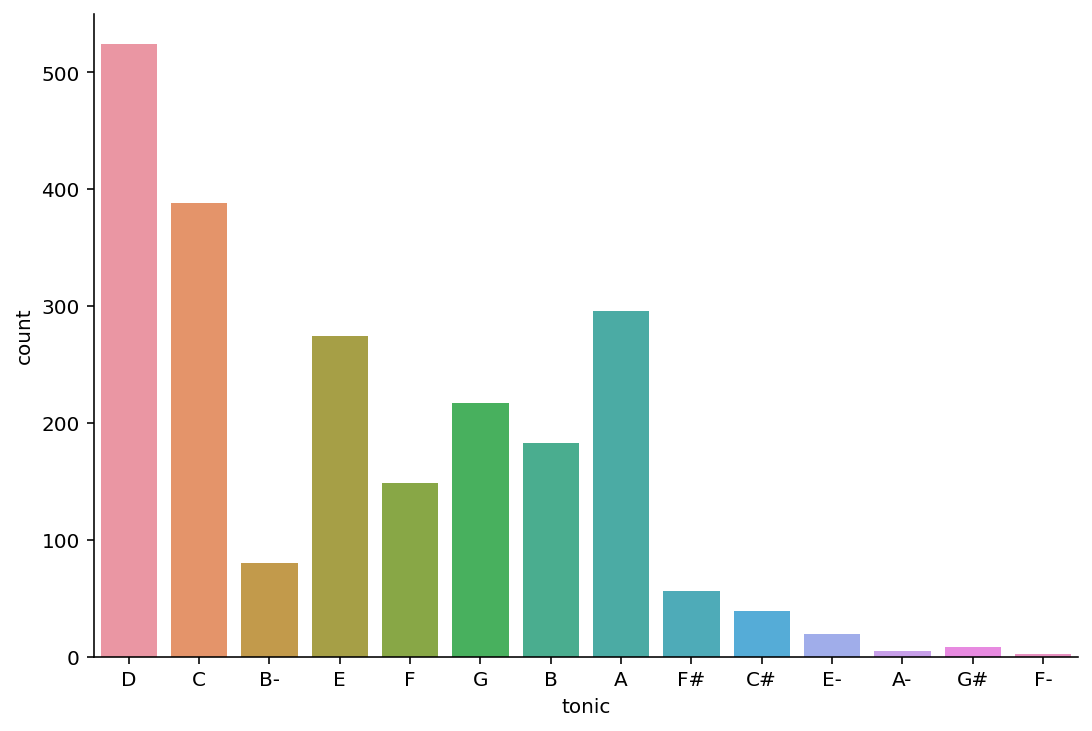

In [30]:
sns.catplot(x="tonic", kind="count", data=CFS_full, aspect=1.5)

Next, the plot below depicts the number of CFS in each annotated region

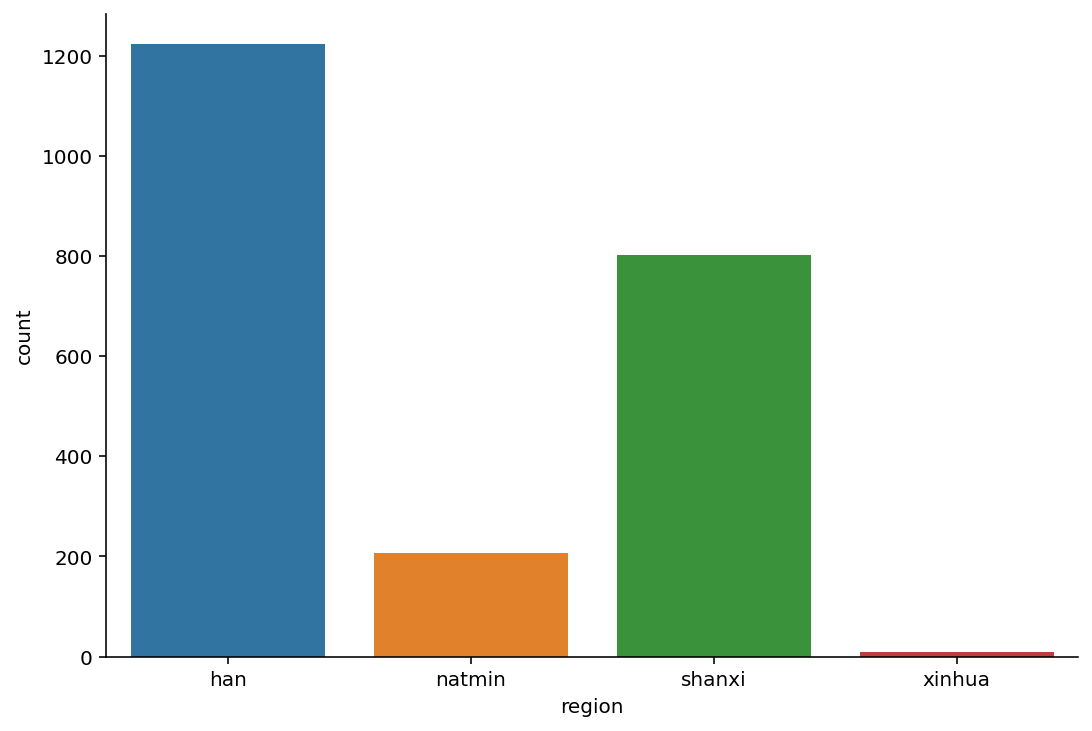

In [29]:
sns.catplot(x="region", kind="count", data=CFS_full, aspect=1.5)

We observe that the highest number of pieces are from Han (\~1200), followed by Shanxi (\~800). The least number of pieces are from Natmin (\~200) and Xinhua (=10). Clearly, the number of songs from the Xinhua region is underrepresented in the dataset when compared with other regions.

The following plots depicts the number of notes in each piece across the four regions.

Text(0.5, 1.0, 'Distribution of length of Chinese Folk Songs from each region')

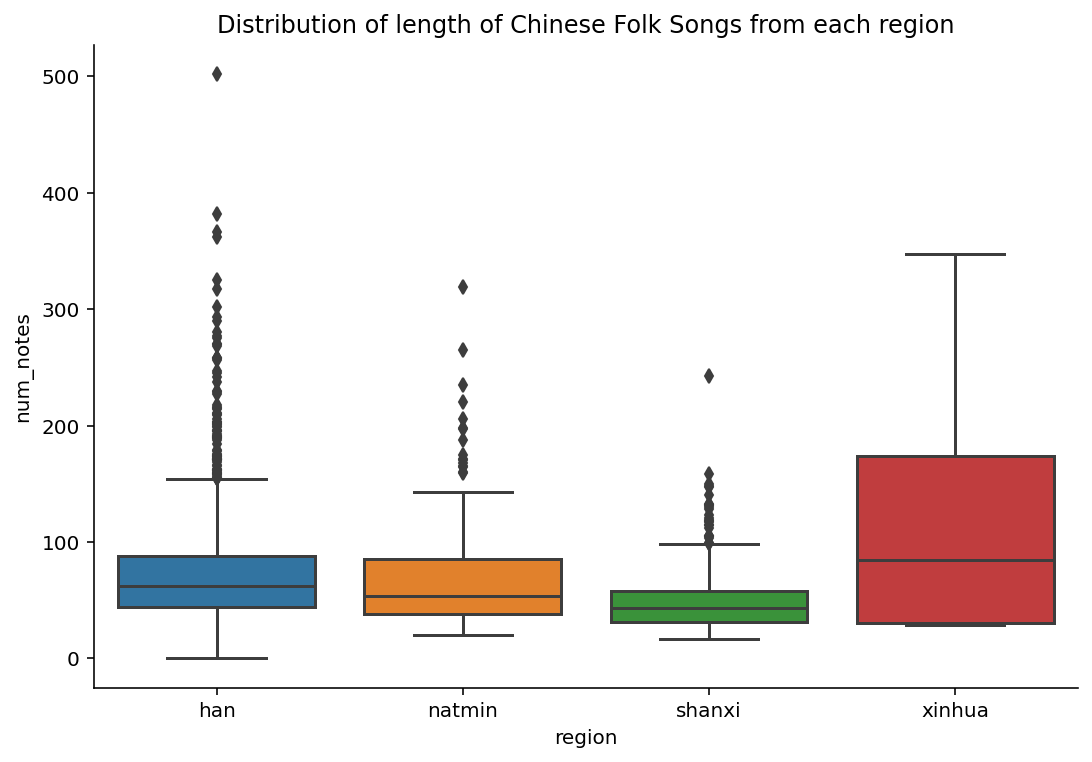

In [31]:
sns.catplot(x="region", y="num_notes", data=CFS_full, kind="box", aspect=1.5)
plt.title("Distribution of length of Chinese Folk Songs from each region")

On average each piece has 70 to 75 notes in the Han, Shanxi, and Natmin regions, whereas the mean number of notes in Xinhua is around 120

Similarly to the number of notes, we look at the number of pitch classes present in pieces across regions.

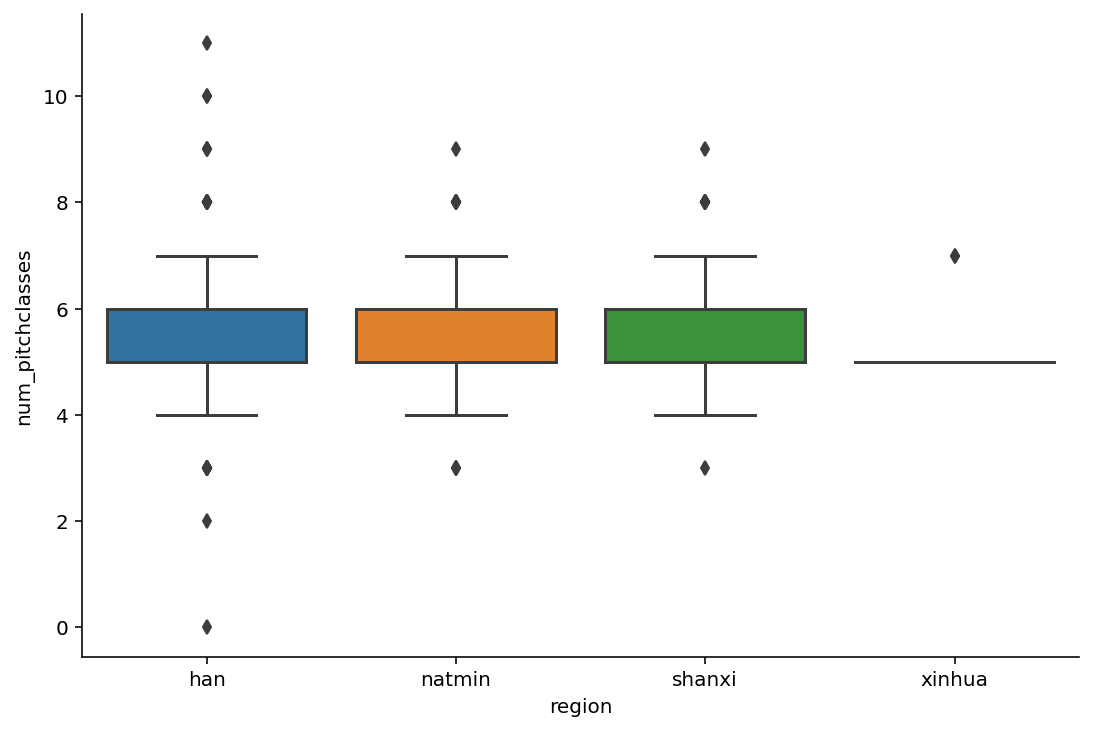

In [32]:
sns.catplot(x="region", y="num_pitchclasses", data=CFS_full, kind="box", aspect=1.5)

The plot aboce clearly indicates the mean as being 5, thus reinforcing our assumptions that the pieces are in pentatonic scale.

# 3. Exploratory analysis

**Remove for submission**

Perform an exploratory analysis on your data. In this section of your report please address the following points:
- [ ] Which analyses or experiments did you perform as part of your exploratory analysis of the data and what are the results? Choose suitable visualizations to show your results.
- [ ] How do the results relate to your hypotheses?
- [ ] Did you find interesting or unexpected things? How do they influence the development of your project?
- [ ] What are problems that you encountered? How could you plan to deal with them?
- [ ] Discuss how the data enables you to answer your research question(s).
- [ ] Formulate educated guesses on your outcomes based on this data.
- [ ] Reflect on how, at the end of the analysis, you will be able to tell whether these outcomes have manifested or not and how confident you will possibly be about this assessment.


## 3.1 Geographical information

As our research questions are based on geographical information, we are first interested to explore it. As it is not clear what regions are understood by Han, Natmin and Xhinhua, we will geolocalise the precise location of each song and put a coloured marker on a world map for each of them. For that purpose, we use `geopy` and `folium`.

The function below takes as input a location name in the format `"Continent, Country, Province, City"` and tries to geolocate it as precisely as most, i.e. begin by the city, following by the province, etc...

In [33]:
cache = dict()
def name_to_geolocation(name):
    geolocator = Nominatim(user_agent = "DH-401 CFS locator")
    names = name.strip(" ").replace(", ", ",").replace(" ", ",").split(",")
    for i in range(len(names)):
        if names[len(names)-1-i] in cache.keys():
            return cache[names[len(names)-1-i]]
        location = geolocator.geocode(names[len(names)-1-i])
        if location is not None:
            break
    cache[names[len(names)-1-i]] = location
    return None

We can now use this function on the column `location` of the `DataFrame` to locate all songs. For each geolocation, we then add a marker on the map. Each region has a different colour:
* Han : Blue
* Shanxi : Red
* Natmin : Black
* Xinhua : Green

Once all markers are added, we can display the map.

In [35]:
map_ = folium.Map()
locations = list()
for _, row in tqdm(CFS_full.iterrows()):
    geolocation = name_to_location(row["location"])
    if geolocation is None:
        continue
    if geolocation.latitude + geolocation.longitude in locations:
        continue
    if row["region"] == "han":
        color = "blue"
    elif row["region"] == "shanxi":
        color="red"
    elif row["region"] == "natmin":
        color="black"
    else:
        color = "green"
    folium.Marker([geolocation.latitude, geolocation.longitude], popup=row["location"], icon=folium.Icon(color=color)).add_to(map_)
    locations.append(geolocation.latitude + geolocation.longitude)
map_

2241it [07:41,  4.86it/s]


*Note* : if you cannot see the interactive map, you need to trust this Notebook or to execute the code.

We directly notice two things on the above map:
* The geolocation is imperfect. Indeed, some locations are found in Europe, which does not make sense. Some of these errors are also due to the fact that names are sometimes followed by a German region name (e.g. "Sichuan, Ostteil").  However the purpose of this map is not to get precise locations but to get a general idea of what the different regions represent. The markers are clickable in order to verify if the geolocations make sense.
* It clearly appears that the regions are mixed. 
  * The Han region spans the entierty of Western China and also includes many locations inside the Shanxi province.
  * It is impossible to tell what region "Natmin" represents
  * The Shanxi region is the only one that seems correct and contained inside its province. Clicking the few outliers reveal they were misplaced by the geolocator and should be inside the Shanxi province.
  
 
The conclusion of this geographical exploration is that we cannot use these four regions to answer our research questions. Indeed, we would not be able to make any claims about regional differences if the regions overlap and are ill-defined.

Therefore, we decided to make our own regional categories using the following map:


![map](img/map.JPG)

We can now assign our custom region class to each song by looking at its province.

In [36]:
CFS_full['geo_division'] = ''
CFS_full.loc[CFS_full['location'].str.contains('Shanxi|Ningxia|Gansu|Qinghai'), ['geo_division']] = 'Northwest'
CFS_full.loc[CFS_full['location'].str.contains('Neimeng'), ['geo_division']] = 'Neimeng'
CFS_full.loc[CFS_full['location'].str.contains('Shandong|Hebei|Liaoning|Jilin|Heilongjiang'), ['geo_division']] = 'Northeast'
CFS_full.loc[CFS_full['location'].str.contains('Jiangsu|Anhui|Zhejiang'), ['geo_division']] = 'Jiangzhe'
CFS_full.loc[CFS_full['location'].str.contains('Hubei|Hunan|Henan|Jiangxi'), ['geo_division']] = 'Central'
CFS_full.loc[CFS_full['location'].str.contains('Fujian|Guangdong|Taiwan'), ['geo_division']] = 'Southeast'
CFS_full.loc[CFS_full['location'].str.contains('Sichuan|Chongqing|Yunnan|Guangxi|Hainan'), ['geo_division']] = 'Southwest'
CFS_full.loc[CFS_full['location'].str.contains('Xinjiang'), ['geo_division']] = 'Jiang' 
CFS_full.loc[CFS_full['geo_division'] == '', ['geo_division']] = 'Null' 
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",Northwest


We can now display the count of songs in each of our 8 regions.

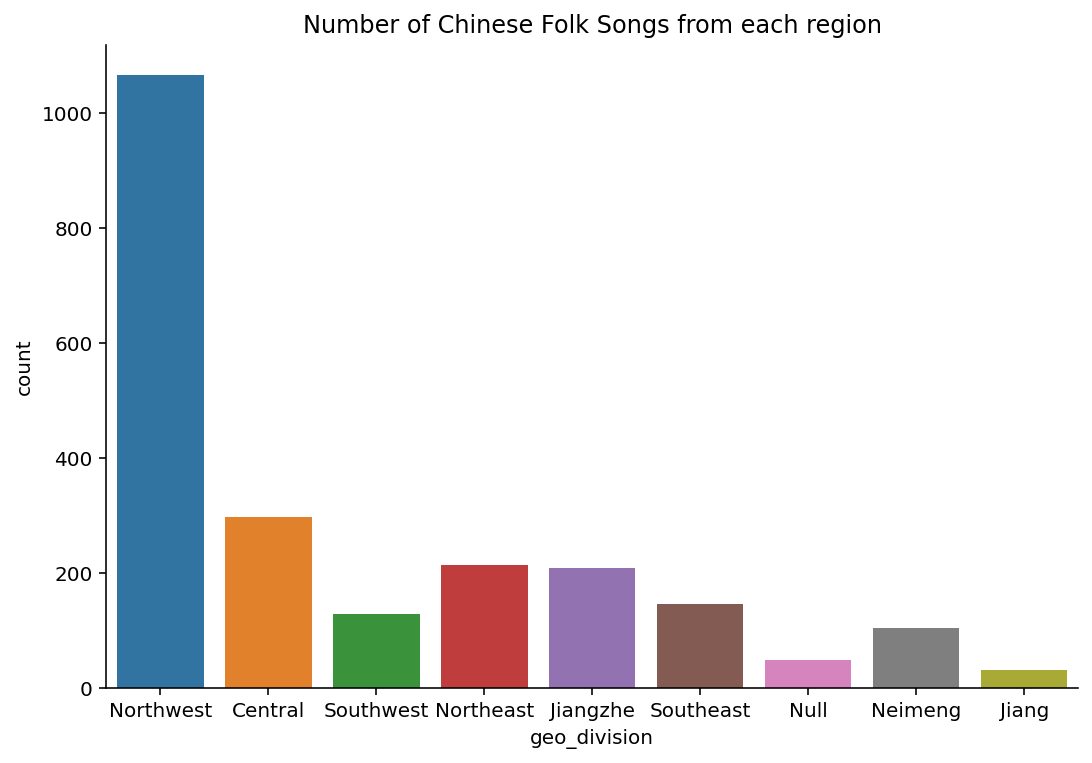

In [38]:
sns.catplot(x="geo_division", kind="count", data=CFS_full, aspect=1.5)
plt.title("Number of Chinese Folk Songs from each region")
plt.show()

Here we observe that the "Northwest" region possesses by far the most songs, but that other regions still contain enough songs for analysis. Only the "Jiang" region has less than 100 songs.

## 3.2 Pitch statistics

In this section, we try to plot the combined pitch statistics of all the pieces separated by regions. There is a pitch statistics plot and pitch-class before transposing all the pieces in C and after transposing.

First, we create empty dictionaries to store the pitches and pitches classes before and after transposition with region name as key and values as a list of pitches (pitch classes) of all pieces belonging to that region.

In [15]:
region_pitch_stat = {}
region_pitchclass_stat = {}
region_pitch_transposed_stat = {}
region_pitchclass_transposed_stat = {}

pitchclasses_defcount = {"A":0, "A#": 0, "A-": 0,
                 "B":0, "B#": 0, "B-": 0,
                 "C":0, "C#": 0, "C-":0,
                 "D":0, "D#": 0, "D-":0,
                 "E":0, "E#": 0, "E-":0,
                 "F":0, "F#": 0, "E-":0,
                 "G":0, "G#": 0, "G-":0} 

for gloc in regions: 
    region_df = CFS_full[CFS_full["region"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_pitchclass_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_pitchclass_transposed_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])

To plot the pitch statistics, we count the occurrence of each pitch and then normalize the count between 0 and 1. Then we plot a bar chart

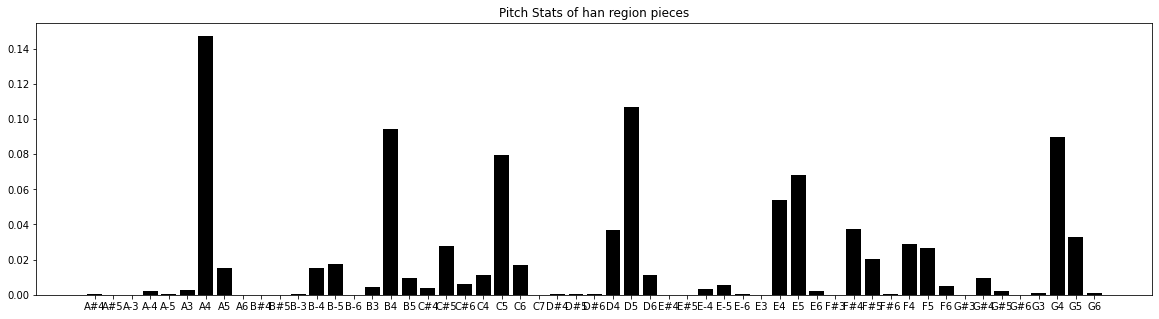

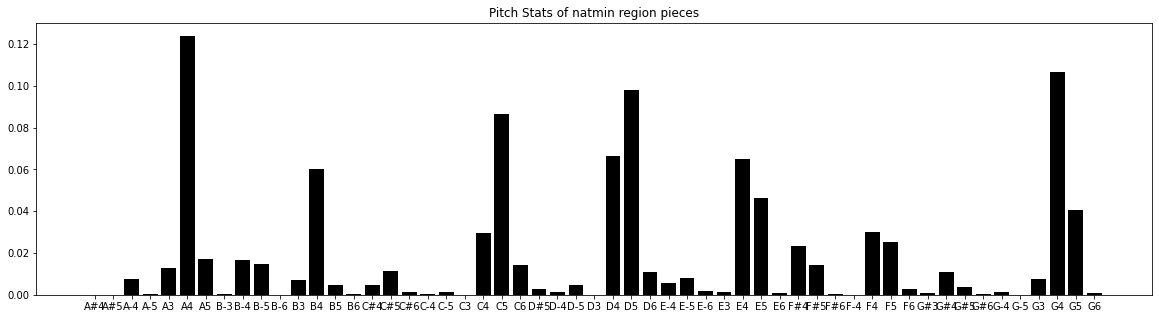

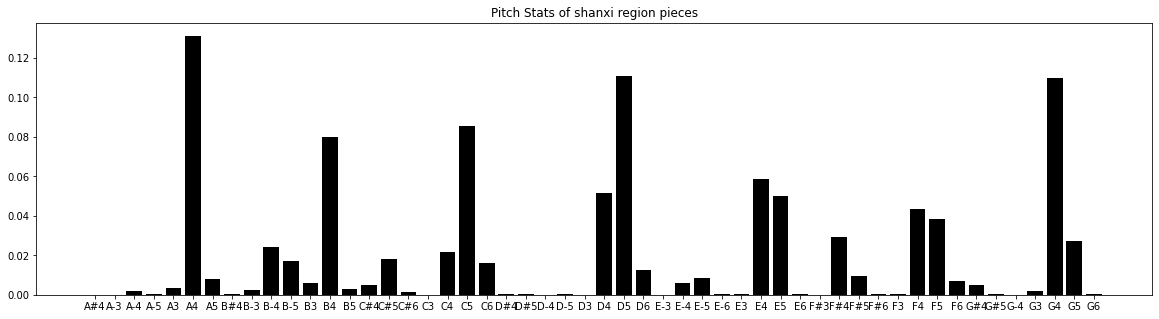

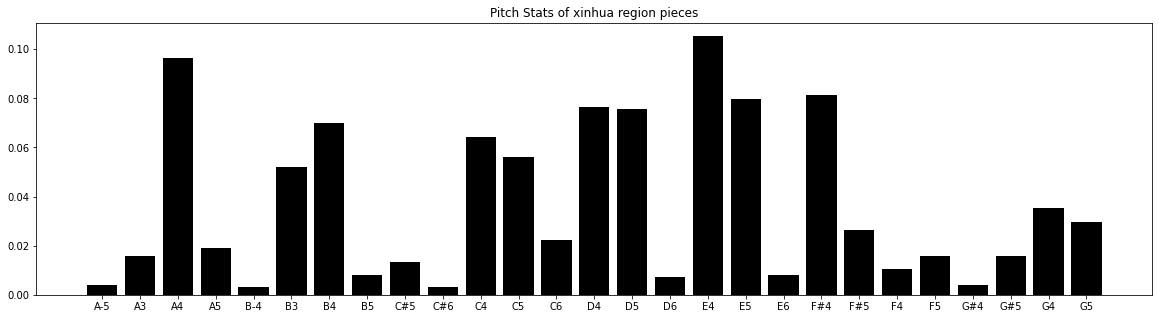

In [16]:
region_pitch_counts = {}
for gloc in region_pitch_stat:
    
    counter = Counter(region_pitch_stat[gloc])
    pitch_fractions = {i:counter[i] / len(region_pitch_stat[gloc]) for i in counter}
    region_pitch_counts[gloc] = sorted(pitch_fractions.items(), key=lambda pair: pair[0])
    
    x, y = zip(*region_pitch_counts[gloc])
    
    plt.bar(x, y, color='black')
    plt.title("Pitch Stats of {} region pieces".format(gloc))
    plt.show()

While plotting the pitch classes is similar to that of pitches, we additionally add 0 counts to those pitch classes that have not occurred in any piece belonging to the region and we sort the based on the fraction of occurrence instead of alphabetical order of the pitch classes.

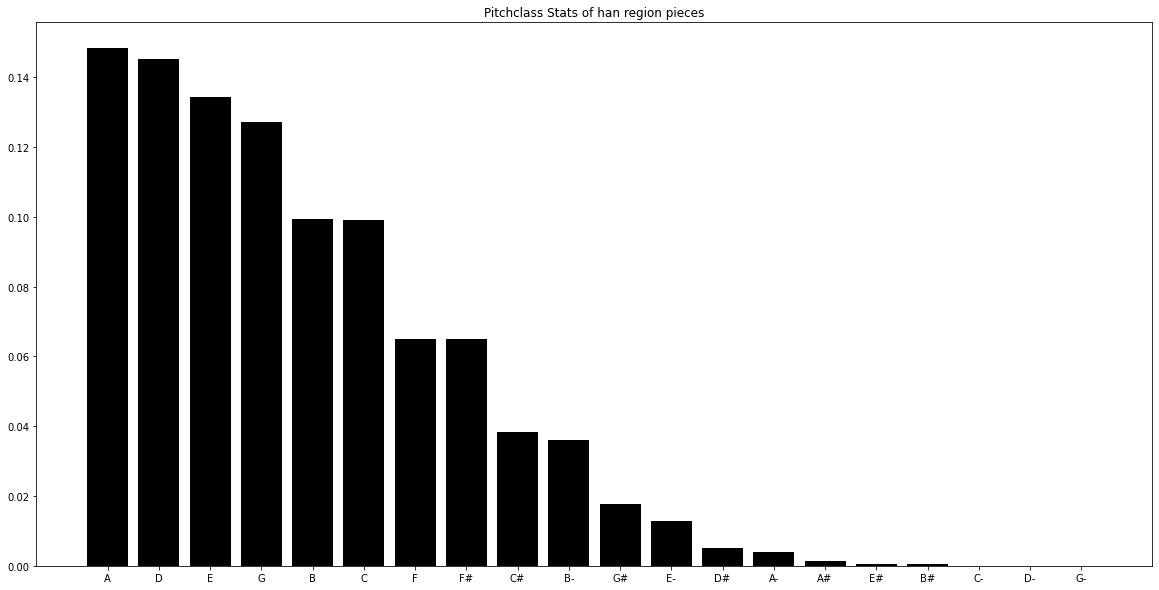

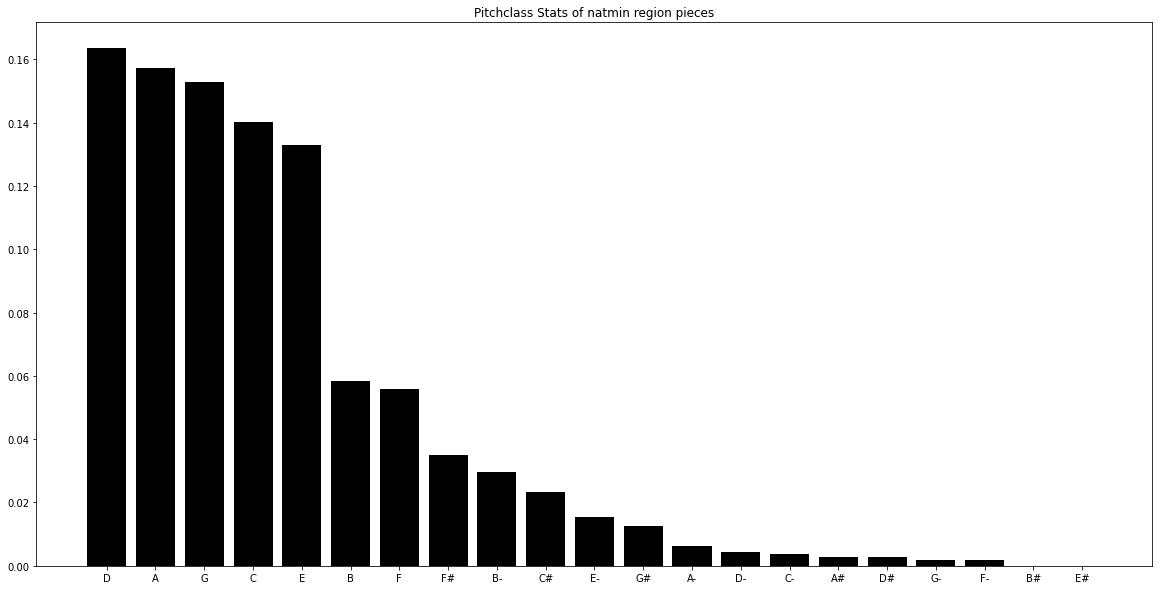

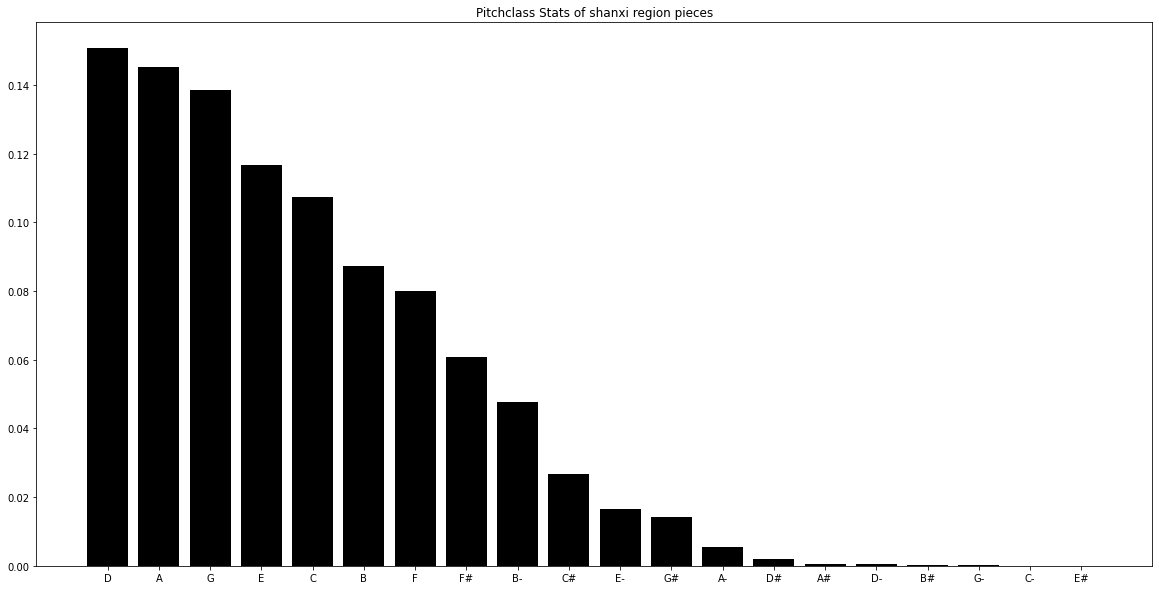

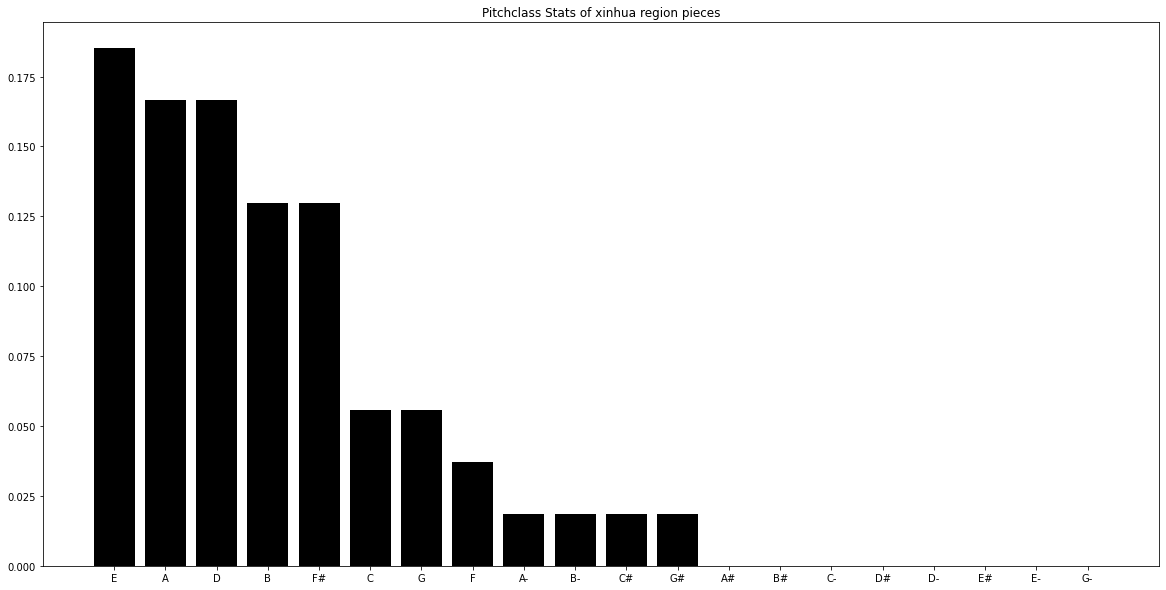

In [26]:
region_pitchclass_counts = {}
for gloc in region_pitchclass_stat:
    
    counter = Counter(region_pitchclass_stat[gloc])
    pitchclass_fractions = {i:counter[i] / len(region_pitchclass_stat[gloc]) for i in counter}
    pitchclass_fractions = {**pitchclasses_defcount, **pitchclass_fractions}
    region_pitchclass_counts[gloc] = sorted(pitchclass_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_pitchclass_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitchclass Stats of {} region pieces".format(gloc))
    plt.show()

The plotting of pitch and pitch classes after transposing is similar to the previous ones.

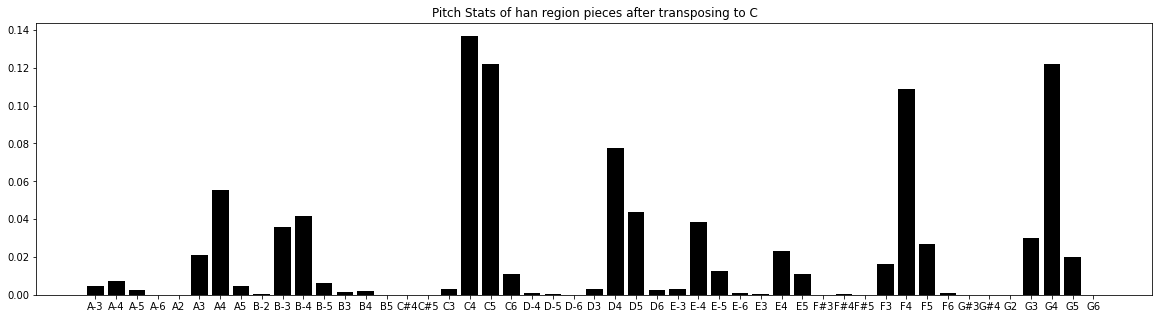

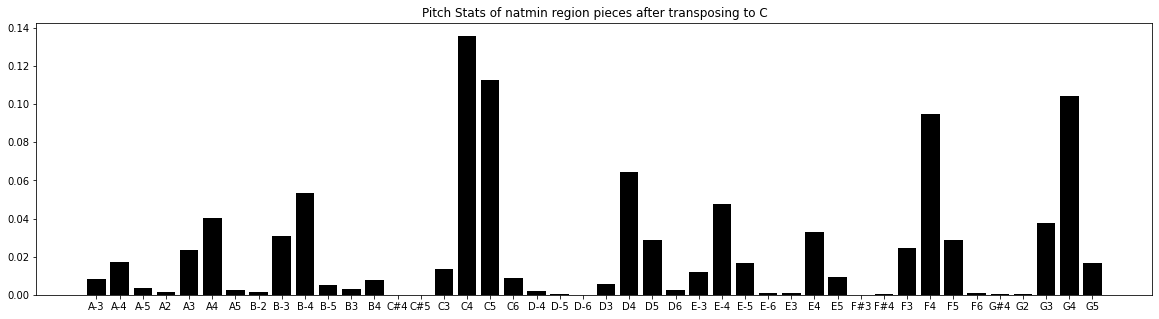

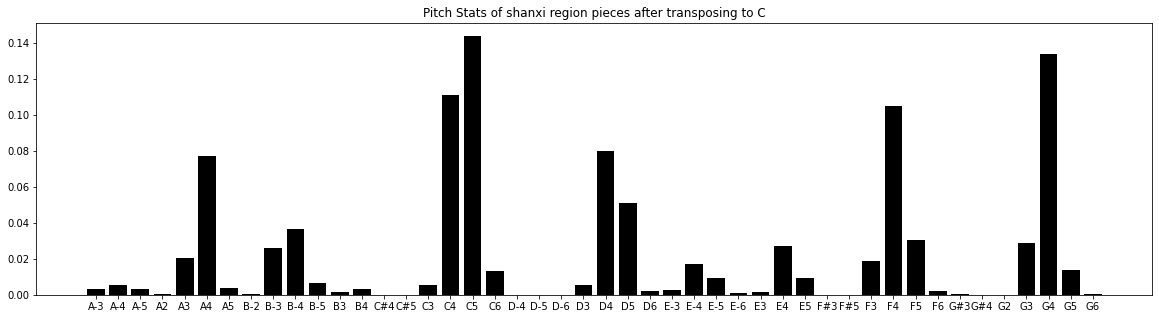

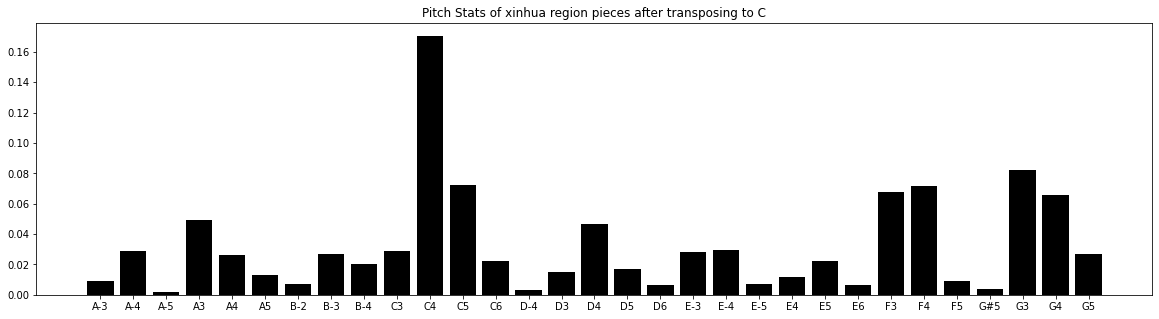

In [18]:
region_pitch_transposed_counts = {}
for gloc in region_pitch_transposed_stat:
    
    counter = Counter(region_pitch_transposed_stat[gloc])
    pitch_transposed_fractions = {i:counter[i] / len(region_pitch_transposed_stat[gloc]) for i in counter}
    
    region_pitch_transposed_counts[gloc] = sorted(pitch_transposed_fractions.items(), key=lambda pair: pair[0])
    x, y = zip(*region_pitch_transposed_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitch Stats of {} region pieces after transposing to C".format(gloc))
    plt.show()

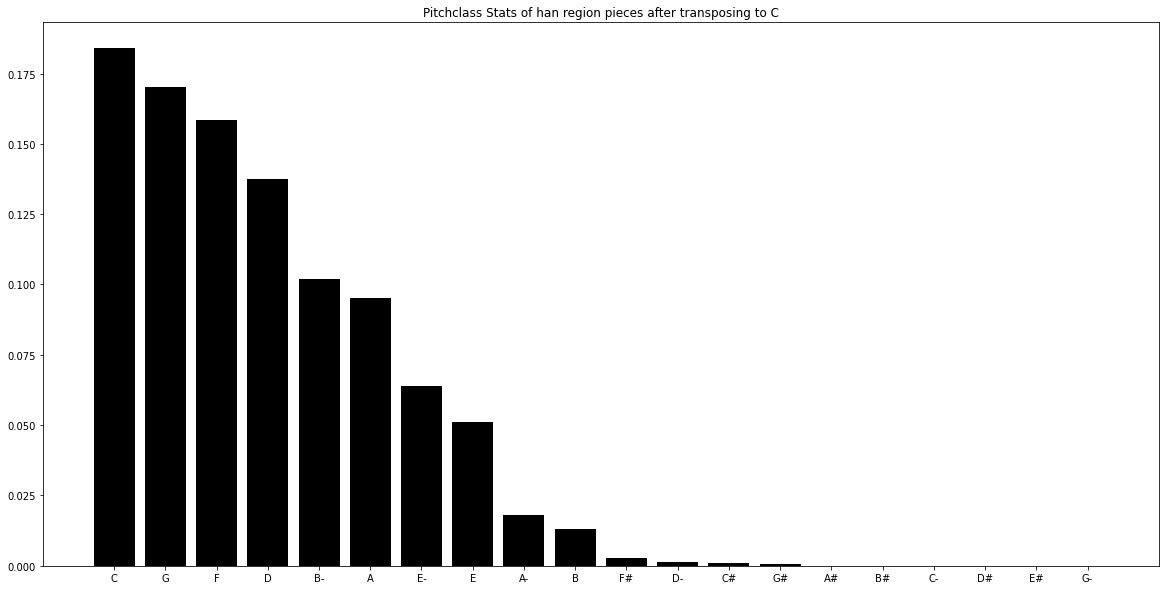

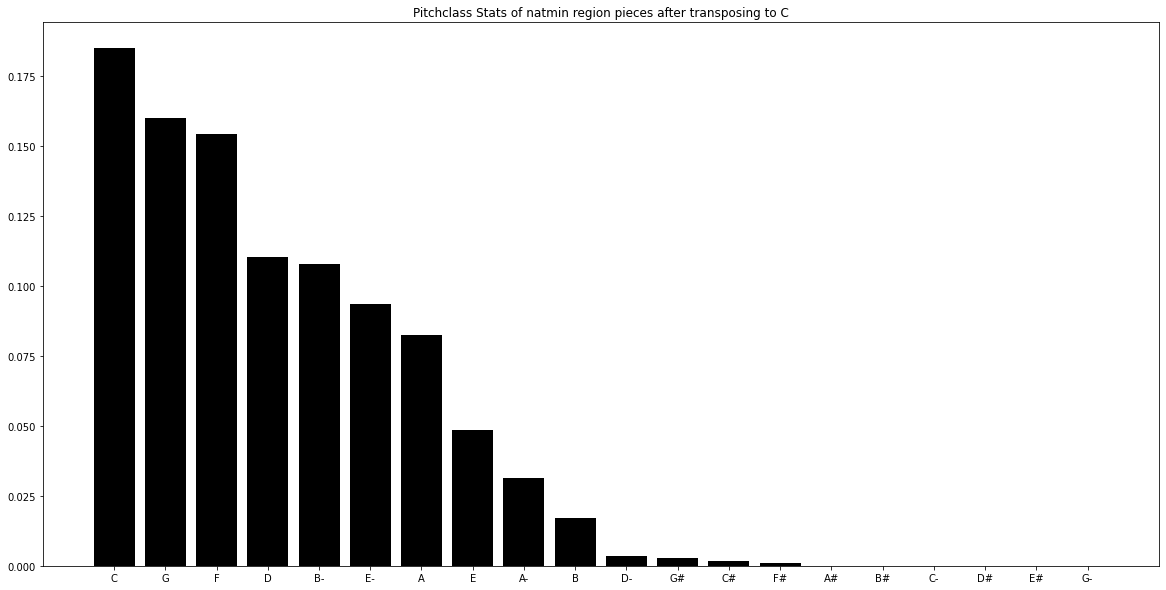

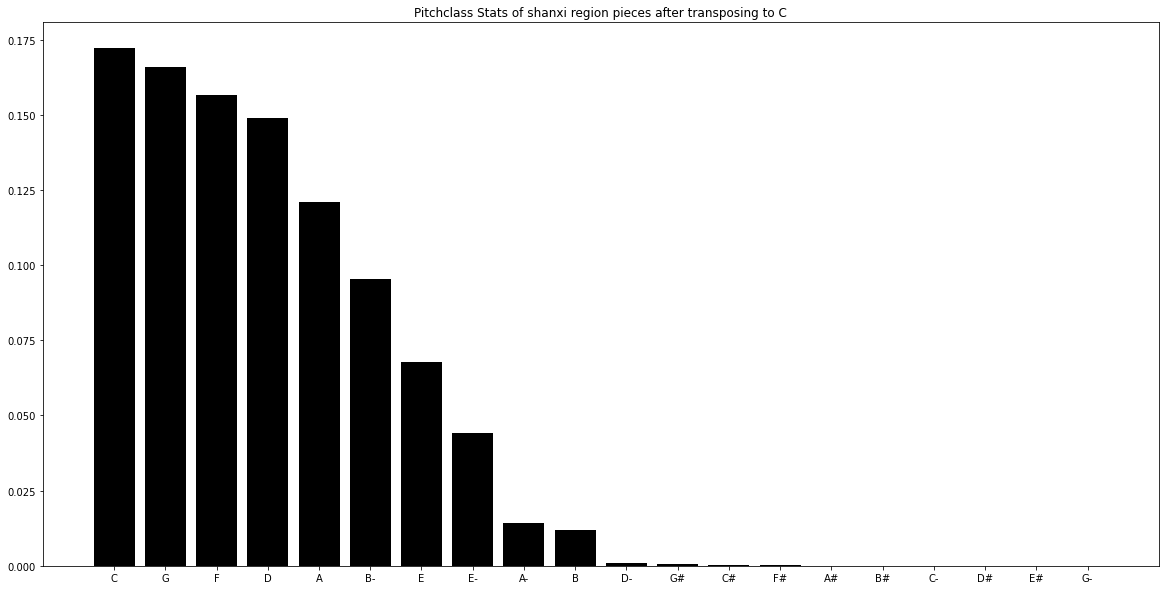

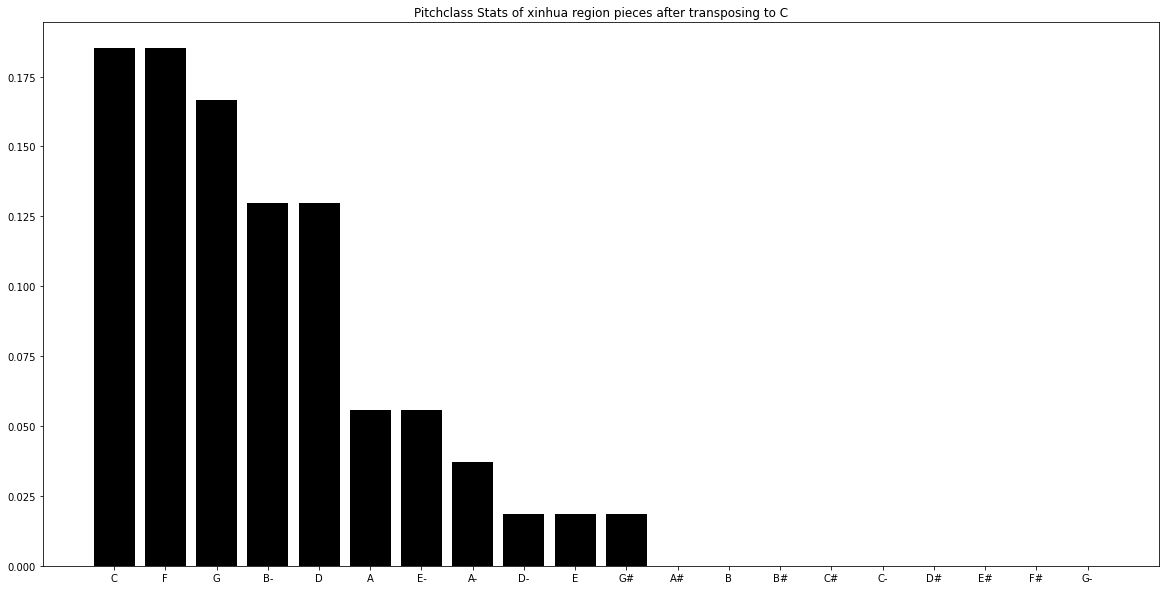

In [25]:
region_pitchclass_transposed_counts = {}
for gloc in region_pitchclass_transposed_stat:
    
    counter = Counter(region_pitchclass_transposed_stat[gloc])
    pitchclass_transposed_fractions = {i:counter[i] / len(region_pitchclass_transposed_stat[gloc]) for i in counter}
    pitchclass_transposed_fractions = {**pitchclasses_defcount, **pitchclass_transposed_fractions}
    region_pitchclass_transposed_counts[gloc] = sorted(pitchclass_transposed_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_pitchclass_transposed_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitchclass Stats of {} region pieces after transposing to C".format(gloc))
    plt.show()

Next, we look at the pitch transition in each region. For this, we create a network with pitch classes as nodes and the transitions between them as edges.

### Pitch Class Transition 

We create a dictionary to store the probability of transitions of the pitch classes in all pieces belonging to one region. The name of the region is the key of the mentioned dictionary and the value is a nested dictionary with keys as the starting pitch class and the values as dictionaries with key as the transitioned pitch class and value as the count of such occurrence.

Lastly, we normalize the transitions count of a pitch so that the sum is 1 and we can interpret it as a probability.

In [20]:
pitchclass_trasition = {}

for gloc in tqdm(music_data):
    gloc_pitchclass_transition = {}
    for score in music_data[gloc]["scores"]:
        for part in score.parts:
            for measure in part:
                if type(measure) is not stream.Measure:
                    continue
                prev = None
                for note_ in measure:
                    if type(note_) is not note.Note:
                        continue
                    if prev != None:
                        if prev not in gloc_pitchclass_transition:
                            gloc_pitchclass_transition[prev] = {}
                        if note_.name not in gloc_pitchclass_transition[prev]:
                            gloc_pitchclass_transition[prev][note_.name] = 1
                        else:
                            gloc_pitchclass_transition[prev][note_.name] += 1
                    prev = note_.name
    
    for pclass in  gloc_pitchclass_transition:
        tot_sum = sum( gloc_pitchclass_transition [pclass].values())
        for ptransclass in  gloc_pitchclass_transition[pclass]:
             gloc_pitchclass_transition[pclass][ptransclass] =  gloc_pitchclass_transition[pclass][ptransclass] / tot_sum
            
    pitchclass_trasition[gloc] = gloc_pitchclass_transition    

100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


In [21]:
# function to sort a nested dictionary based on key
# credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb

def sort_dict(item):
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

Now using the pitch class transitions in each region we create a network with pitch class as the nodes and creating an edge in case there is a transition between the nodes. The graph will be directed meaning there exists an edge only in the direction where the pitch transition occurs.

We create a `plot_network` function to plot the created network that sizes the nodes of the network based on their degree and the thickness of edges based on the probability of transition meaning the darker the edge the probable the transition between those pitch classes.

Apart from plotting the graph, we also plot the transition probability as heatmaps to help in interpreting the probabilities. To create the heatmap, we first convert the transition probabilities from a dictionary to a data frame and use it to plot the heatmap. As the transitions are not bidirectional, the heatmap would not look symmetric.

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
def plot_network(graph):
    weighted_degree = dict(graph.degree(weight='weight'))
    edges = graph.edges()
    weights = [5 * graph[u][v]['weight'] for u,v in edges]
    nx.draw_circular(graph, with_labels=True, alpha = 0.6, width=weights,
                  node_size=[v * 1000 for v in weighted_degree.values()])
    plt.axis("off")

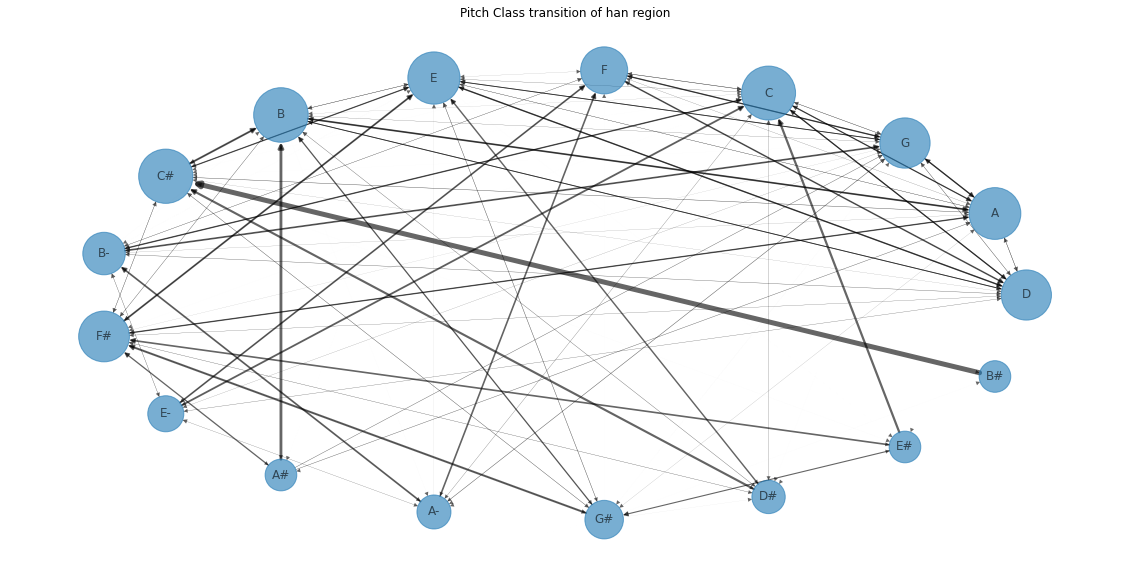

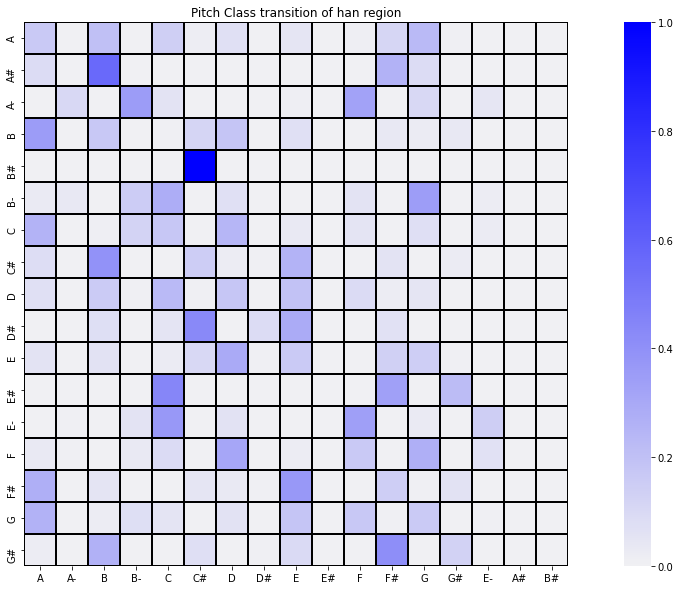

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


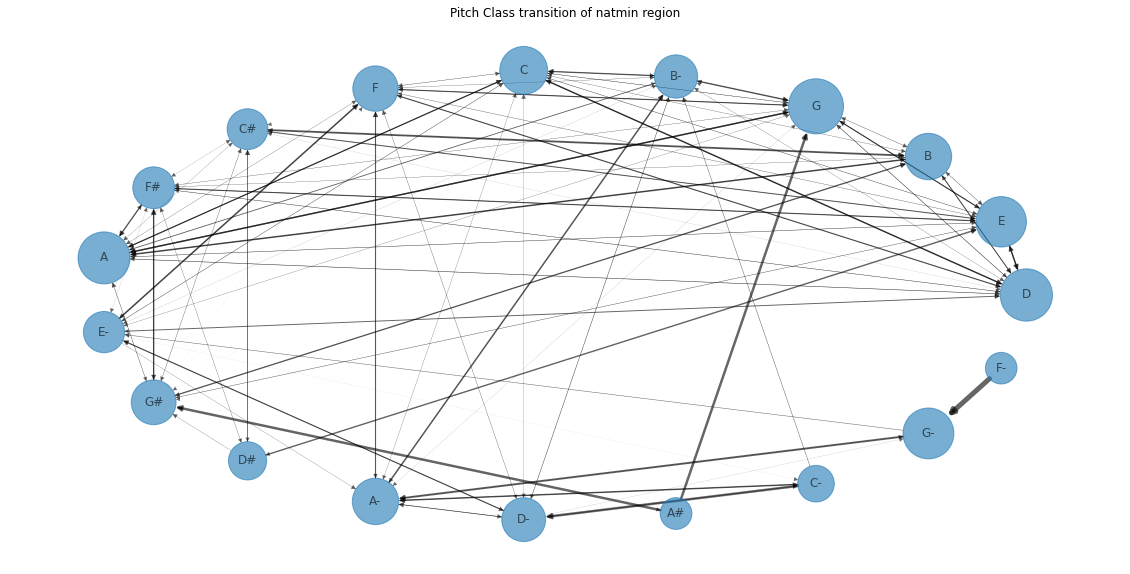

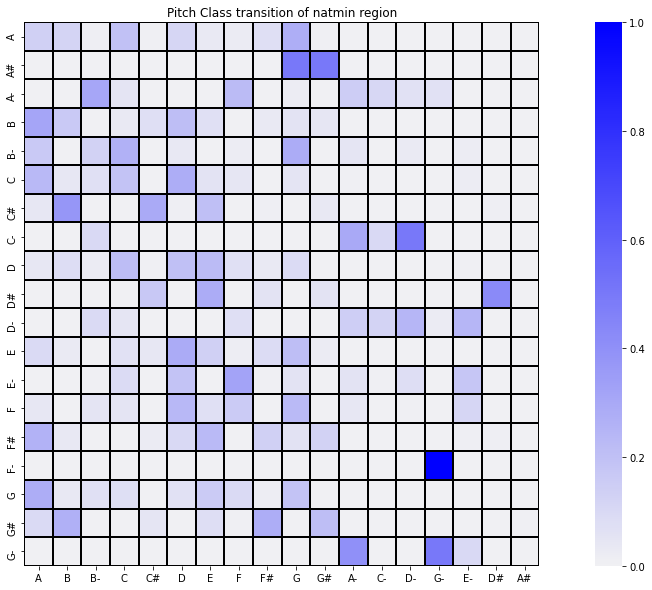

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


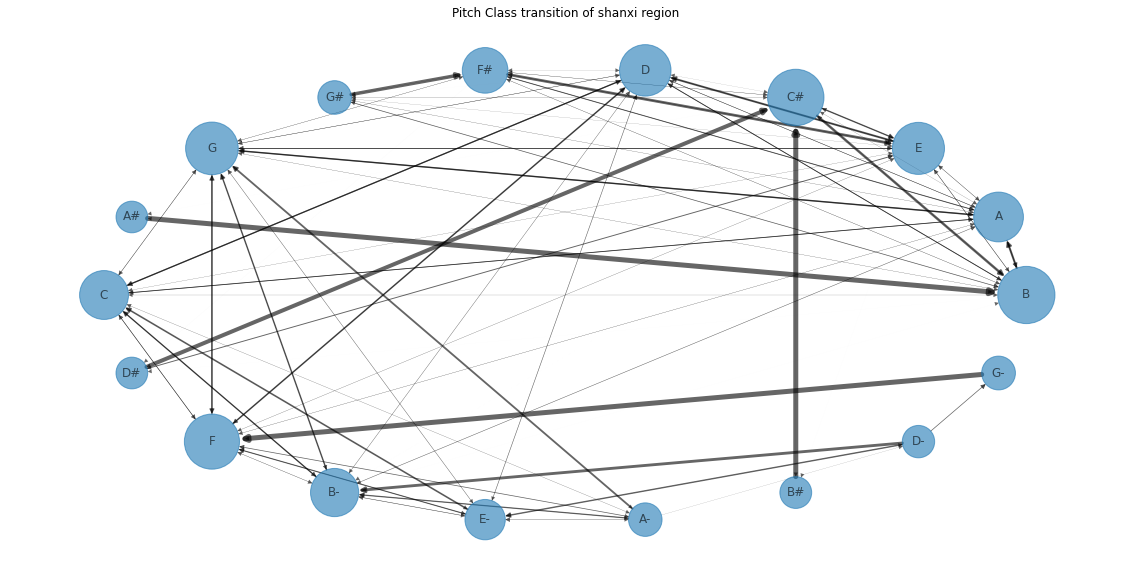

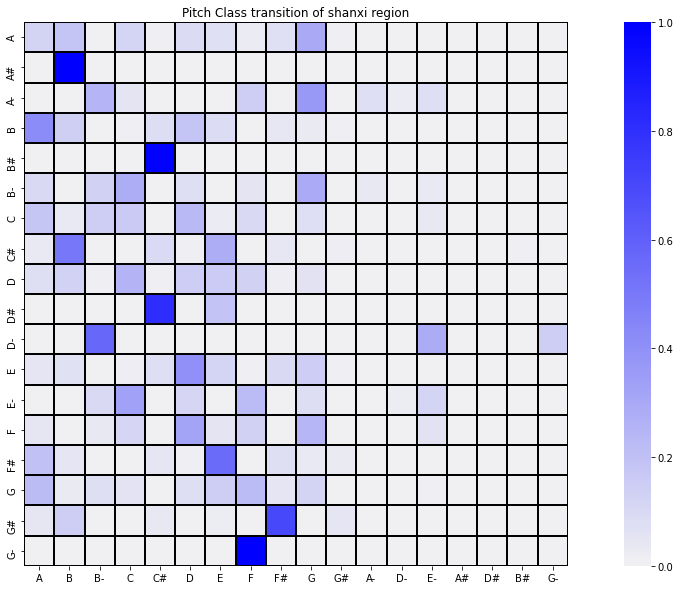

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


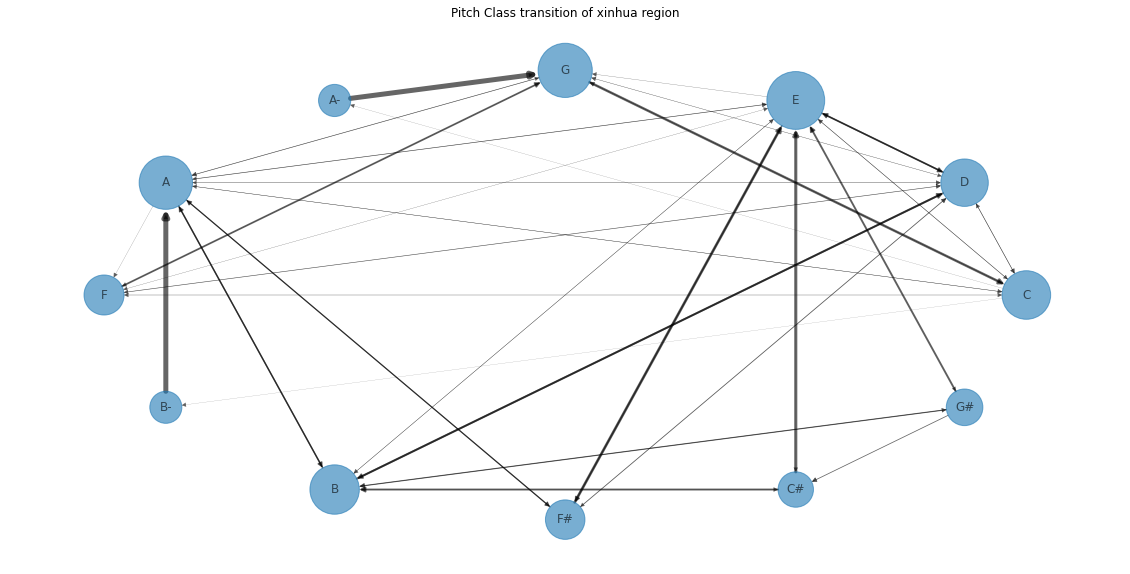

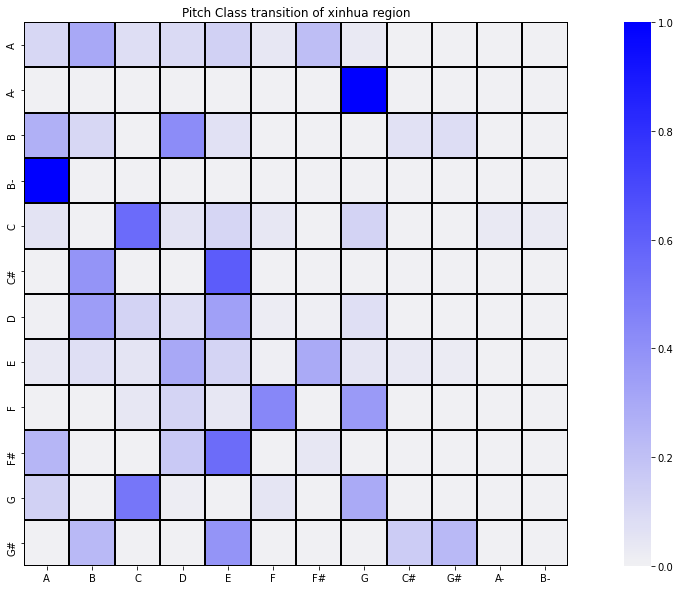

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
colormap = sns.color_palette("light:b", as_cmap=True)
for gloc in regions:
    gloc_graph = nx.DiGraph((k, v, {'weight': weight}) for k, vs in pitchclass_trasition[gloc].items() for v, weight in vs.items())
    plt.title("Pitch Class transition of {} region".format(gloc))
    plot_network(gloc_graph)
    plt.show()
    
    sorted_probs = sort_dict(pitchclass_trasition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    plt.title("Pitch Class transition of {} region".format(gloc))
    plt.show()
    
    print("--"*100)